# Permutation Flow-Shop Scheduling Problem

This is a variant of the Flot-shop scheduling problem (FSSP) in which the sequence of jobs is the same in every machine.

$$
 \begin{align}
     \text{min} \quad & C_{\text{max}} \\
     \text{s.t.} \quad & h_{m-1,k} + \sum_{j \in J} p_{j,m-1} x_{j,k} \leq h_{m,k}
         & \forall ~ m \in M \setminus \{1\}; k \in K\\
     & h_{m,k} + \sum_{j \in J} p_{j,m} x_{j,k} \leq h_{m,k+1}
         & \forall ~ m \in M; k \in K \setminus \{|K|\}\\
     & \sum_{j \in J} x_{j,k} = 1
         & \forall ~ k \in K\\
     & \sum_{k \in K} x_{j,k} = 1
         & \forall ~ j \in J\\
     & h_{|M|,|K|} + \sum_{j \in J} p_{j,|M|} x_{j,|K|} \leq C_{\text{max}}\\
     & h_{m,k} \geq 0 & \forall ~ m \in M; k \in K\\
     & x_{j,k} \in \{0, 1\} & \forall ~ j \in J; k \in K\\
 \end{align}
 $$

 You can compare this implementation to MILP solvers at the [end of the notebook](#bonus---milp-model).

In [1]:

import gc
import json
import time

from bnbprob.pafssp import (
    BenchCutoffBnB,
    BenchPermFlowShop,
    CallbackBnB,
    CutoffBnB,
    PermFlowShop,
    plot_gantt,
)
from bnbprob.pafssp.mip import positional_model
from bnbpy import configure_logfile


In [2]:
configure_logfile("pfssp-bench.log", mode="w")

In [23]:
with open("./../data/flow-shop/ta045.json", mode="r", encoding="utf8") as f:
    p = json.load(f)

print(f"{len(p)} Jobs; {len(p[0])} Machines")

50 Jobs; 10 Machines


In [19]:
gc.disable()

## Lazy Upgrade Improvement

In [5]:
problem = PermFlowShop.from_p(p, constructive='neh')
bnb = CutoffBnB(2991)

In [8]:
problem.calc_lb_2m()

1313

In [18]:
start = time.time()
sol = bnb.solve(
    problem, maxiter=1_000_000_000, timelimit=3600
)
end = time.time()
print(f"Solved in {end - start:.3f} s")
print(bnb.explored)
print(sol)

Solved in 2.471 s
80132
Status: OPTIMAL | Cost: 2991.0 | LB: 2991.0


## Benchmark

In [19]:
problem = BenchPermFlowShop.from_p(p, constructive='neh')
bnb = BenchCutoffBnB(2991)

In [20]:
start = time.time()
sol = bnb.solve(
    problem, maxiter=1_000_000_000, timelimit=3600
)
end = time.time()
print(f"Solved in {end - start:.3f} s")
print(bnb.explored)
print(sol)

Solved in 5.371 s
80132
Status: OPTIMAL | Cost: 2991.0 | LB: 2991.0


## Solve from zero

In [ ]:
class MyProb(PermFlowShop):

    def warmstart(self):
        return self.ils_initialization(n_iter=200, d=5, seed=42)

In [24]:
problem = PermFlowShop.from_p(p, constructive="iga")
bnb = CallbackBnB(heur_factor=100, delay_lb5=True)

In [25]:
start = time.time()
sol = bnb.solve(
    problem, maxiter=1_000_000_000, timelimit=3600
)
end = time.time()
print(f"Solved in {end - start:.3f} s")
print(bnb.explored)
print(sol)

Solved in 23.647 s
537658
Status: OPTIMAL | Cost: 2976.0 | LB: 2976.0


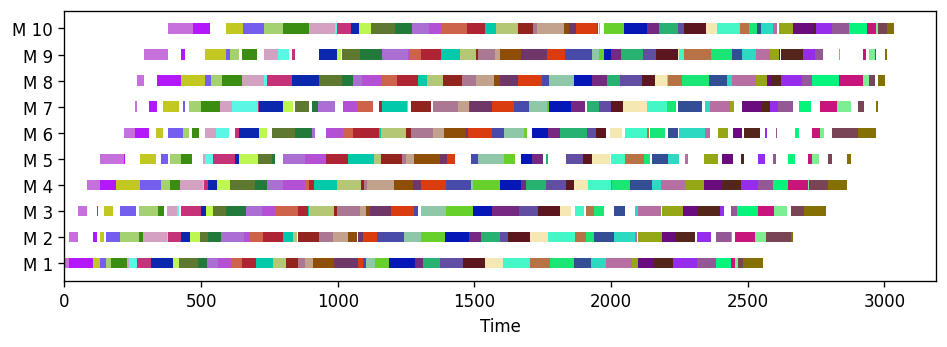

In [22]:
sol.problem.compute_starts()
plot_gantt(sol.problem.sequence, dpi=120, seed=42, figsize=[8, 3])

In [8]:
import pyomo.environ as pyo

model = positional_model(p)

# HiGHS
solver = pyo.SolverFactory('appsi_highs')
solver.options['mip_heuristic_effort'] = 0.1
solver.options['time_limit'] = 600
solver.options['log_file'] = 'Highs.log'
solver.solve(model, tee=True)

Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
RUN!
Coefficient ranges:
  Matrix [1e+00, 1e+02]
  Cost   [1e+00, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 1e+00]
Presolving model
420 rows, 600 cols, 9158 nonzeros  0s
398 rows, 578 cols, 8020 nonzeros  0s

Solving MIP model with:
   398 rows
   578 cols (400 binary, 0 integer, 0 implied int., 178 continuous)
   8020 nonzeros
MIP-Timing:       0.016 - starting analytic centre calculation

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIt

KeyboardInterrupt: 